## Homework 4

In this homework, we will work with two datasets: cell phone usage and population data. The goal is to analyze the growth rate of cell phones per capita in different countries from 2015 to 2019. We will also explore a SQLite database containing user actions and perform some queries to extract useful information.

### Part 1: Cell Phone Usage and Population Data
Using the provided datasets, we will perform the following tasks:
1. Load the cell phone and population data.
2. Check that only valid ISO-3 codes are present in the population data.
3. Fill missing values in the population data.
4. Reshape the cell phone and population data.
5. Merge the data and calculate the number of cell phones per capita.
6. Filter the data for relevant columns.
7. Identify the top 5 countries with the highest cell phones per capita in 2015.
8. Plot the growth rate of cell phones per capita for the top 5 countries from 2015 to 2019.
9. Display the data in a tabular format.

From previous homework, we have the utility function `fill_missing_values` that can be used to fill missing values in the population data. It has been explained in detail in homework 3.

For this part, we will load the cell phone and population data, check for valid ISO-3 codes, where there is a tricky example of a country code that is not valid, and one who only became valid a few years into the dataset. To get rid of the unvalid iso code in a neat way we use the pycountry library to get all valid iso codes and then filter the population data for only those. Since in this case it was only one country that was not valid, we could have done this manually, but this is a more general way to do it. The missing values are filled in the same way as with the cellhpone data, exact for one country, because of the reason described earlier in this paragraph. To combine and merge the dataframes we have to first reshape them, aligning them with the same columns, and then merge them on the iso-3 and year columns.

We then pivot to have years as rows and countries as columns, making it easier to visualize the year-over-year trends.From there we filter in the same way it has been done in previous homeworks, to then plot it.


,Macao,Turks and Caicos Islands,Hong Kong,Virgin Islands (U.S.),United Arab Emirates
Year,,,,,
2015,3.088231,2.402978,2.290401,2.240233,2.007424
2016,3.143510,2.444700,2.398931,2.394062,2.212521
2017,3.210102,2.489710,2.488773,2.549380,2.183431
2018,3.348741,2.528503,2.670209,2.706517,2.199084
2019,3.480735,2.567317,2.863650,2.865875,2.127739


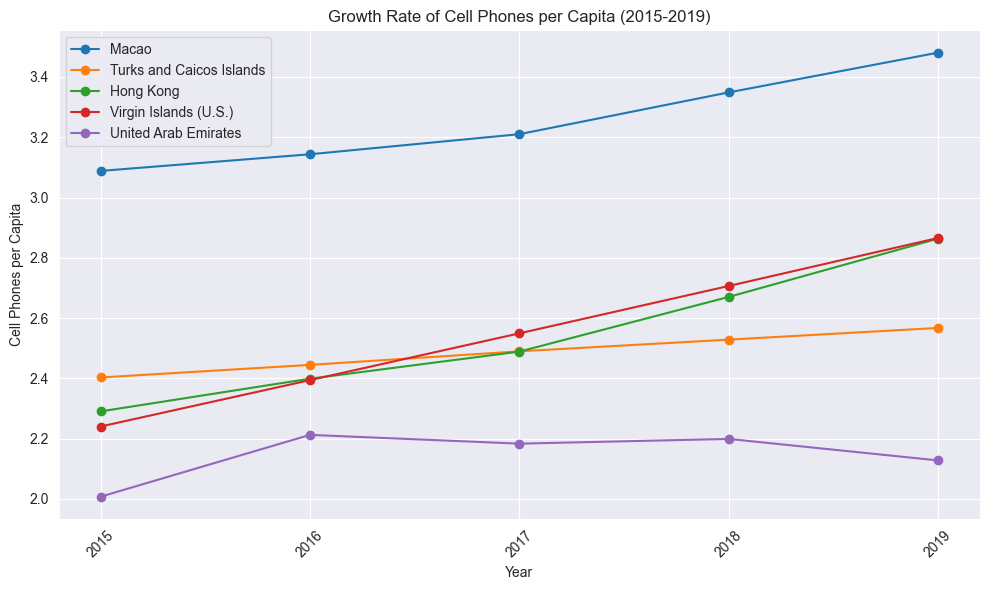

In [2]:
import pandas as pd
import pycountry
import sys
import matplotlib.pyplot as plt

sys.path.append(r'..\su-mt4007')
from homework_4.utils import fill_missing_values
#gitHub check
# Load the data
cell_phones = pd.read_csv('cell_phones_cleaned.csv')
population = pd.read_csv('pop_data.csv')
population = population.drop(columns=['Unnamed: 0'])
country_data = pd.read_csv('country_data.csv')

# Check that only valid iso-3 codes are present in the population data
valid_iso3_codes = [country.alpha_3 for country in pycountry.countries]
valid_pop = population[population['iso-3'].isin(valid_iso3_codes)]

# Fill missing values in the population data
year_columns = valid_pop.columns[2:]
cleaned_pop = valid_pop.apply(lambda row: fill_missing_values(row, year_columns, 0.02), axis=1)
cleaned_pop.to_csv('cleaned_pop.csv', index=False)

# Reshape the cell_phones data
cell_phones_melted = cell_phones.melt(id_vars=['iso-3'], var_name='year', value_name='n_cellphones')

# Reshape the population data
cleaned_pop_melted = cleaned_pop.melt(id_vars=['iso-3'], var_name='year', value_name='population')

# Filter country_data for relevant columns
country_data_filtered = country_data[['name', 'alpha-3']].rename(columns={'alpha-3': 'iso-3'})

combined_data = pd.merge(cell_phones_melted, cleaned_pop_melted, on=['iso-3', 'year'], how='inner')
combined_data['cell_phones_per_capita'] = combined_data['n_cellphones'] / combined_data['population']

combined_data = pd.merge(combined_data, country_data_filtered, on=['iso-3'], how='left')
combined_data.to_csv('combined_data.csv', index=False)

pivot_data = combined_data.pivot(index='year', columns='name', values='cell_phones_per_capita')
pivot_data = pivot_data.rename_axis(index=None, columns=None)
pivot_data = pivot_data.rename_axis('Year', axis='index')

filtered_years = ['2015', '2016', '2017', '2018', '2019']
filtered_columns = [col for col in pivot_data.index.astype(str) if col in filtered_years]
filtered_df = pivot_data.loc[filtered_columns].copy()

top_5_countries_2015 = filtered_df.loc['2015'].nlargest(5)

pivot_data_display = filtered_df.loc[:, top_5_countries_2015.index]
display(pivot_data_display)

# Plot the growth rate
plt.figure(figsize=(10, 6))
for country in top_5_countries_2015.index:
    plt.plot(filtered_df.index, filtered_df[country], marker='o', label=country)

plt.title('Growth Rate of Cell Phones per Capita (2015-2019)')
plt.xlabel('Year')
plt.ylabel('Cell Phones per Capita')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Part 2: SQLite Database Queries
In this part, we will work with a SQLite database containing user actions. We will perform the following tasks:
1. Retrieve usernames of all users who have performed the "signup" action.
2. Find the total number of log entries for each user and display user_id, username, and count.
3. Identify users who have both logged in and signed up on the same day.

We first want to, after connecting to the SQLite database, retrieve the usernames of all users who have performed the "signup" action. We can use a simple SQL query to filter the rows where the action is "signup" and then retrieve the distinct usernames. For the second task, we want to find the total number of log entries for each user. We can group the rows by user_id and username and then count the number of log entries for each user. Finally, for the third task, we want to identify users who have both logged in and signed up on the same day. We can achieve this by joining the user_actions table with itself on the user_id and timestamp columns and then filtering the rows where one action is "signup" and the other is "login" on the same day.

In [3]:
import sqlite3 as sql

# Connect to the SQLite database
conn = sql.connect('user_actions.db')
cursor = conn.cursor()

# Task 1: Retrieve usernames of all users who have performed the "signup" action
cursor.execute("""
    SELECT DISTINCT username
    FROM user_actions
    WHERE action = 'signup';
""")
signup_users = cursor.fetchall() # Fetch all rows
print("Usernames of users who performed 'signup':")
for user in signup_users:
    print(user[0])

# Task 2: Find the total number of log entries for each user and display user_id, username, and count
cursor.execute("""
    SELECT user_id, username, COUNT(*) as log_count
    FROM user_actions
    GROUP BY user_id, username;
""")
log_entries = cursor.fetchall()
print("\nTotal number of log entries for each user:")
for entry in log_entries:
    print(f"User ID: {entry[0]}, Username: {entry[1]}, Log Count: {entry[2]}")

# Task 3: Identify users who have both logged in and signed up on the same day
cursor.execute("""
    SELECT DISTINCT ua1.user_id, ua1.username
    FROM user_actions ua1
    JOIN user_actions ua2 ON ua1.user_id = ua2.user_id AND date(ua1.timestamp) = date(ua2.timestamp)
    WHERE ua1.action = 'signup' AND ua2.action = 'login';
""")
same_day_actions = cursor.fetchall()
print("\nUsers who logged in and signed up on the same day:")
for user in same_day_actions:
    print(f"User ID: {user[0]}, Username: {user[1]}")

# Close the connection
conn.close()

Usernames of users who performed 'signup':
user34
user28
user1
user24
user15
user20
user18
user25
user3
user9
user27
user16
user17
user4
user8
user13
user19
user31
user10
user23
user11
user33
user12
user29
user21
user6
user14
user30
user7
user26
user22
user5
user35
user2
user32

Total number of log entries for each user:
User ID: 1, Username: user1, Log Count: 104
User ID: 2, Username: user2, Log Count: 149
User ID: 3, Username: user3, Log Count: 108
User ID: 4, Username: user4, Log Count: 436
User ID: 5, Username: user5, Log Count: 192
User ID: 6, Username: user6, Log Count: 457
User ID: 7, Username: user7, Log Count: 362
User ID: 8, Username: user8, Log Count: 329
User ID: 9, Username: user9, Log Count: 118
User ID: 10, Username: user10, Log Count: 170
User ID: 11, Username: user11, Log Count: 328
User ID: 12, Username: user12, Log Count: 209
User ID: 13, Username: user13, Log Count: 470
User ID: 14, Username: user14, Log Count: 320
User ID: 15, Username: user15, Log Count: 35
User I

### Part 3: Regular Expressions / Regex

In this part, we will work with a text file containing comments. We will perform the following tasks:
1. Extract all hashtags from a comment.
2. Check if a comment mentions both "#programming" and "#python".
3. Test the functions on the first two comments in the file.
4. Display the hashtags in the first comment and check if the second comment mentions both "#programming" and "#python".

For the first part of the regex task, we want to simply find all hashtags in a comment. We can use the regex pattern `r'#\w+'` to match any word starting with a `#`. For the second part, we want to check if a comment mentions both "#programming" and "#python" in any order. We can use the regex pattern `r'#programming.*#python|#python.*#programming'` to match both hashtags in any order.

re.findall - Return all non-overlapping matches of pattern in string, as a list of strings.
re.search - Scan through string looking for a match to the pattern, returning a match object, or None if no match was found.


In [1]:
import re
import pandas as pd
comments = pd.read_csv("comments.txt", header=None, names=["comment"])

# Function to extract all hashtags from a comment
def extract_hashtags(comment):
    return re.findall(r'#\w+', comment)

# Function to check if comment mentions both "#programming" and "#python"
def mentions_programming_and_python(comment):
    return bool(re.search(r'#programming.*#python|#python.*#programming', comment, re.IGNORECASE))

# Test on comment 1
print(comments.iloc[0])
comment_to_check = comments.iloc[0]['comment'] if len(comments) > 0 else ""
hashtags = extract_hashtags(comment_to_check)
print(f"Hashtags in comment 1: {hashtags}")

# Check comment 2 for mentions of both programming and python
if len(comments) > 1:
    comment_to_check_2 = comments.iloc[1]['comment']
    matches = mentions_programming_and_python(comment_to_check_2)
    print(f"Comment 2 mentions both #programming and #python: {matches}")
else:
    print("Comment 2 not available.")

comment    1. "Great post! #programming #tips"
Name: 0, dtype: object
Hashtags in comment 1: ['#programming', '#tips']
Comment 2 mentions both #programming and #python: False
